In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "pharmacy_otc_sales_data.csv"

# Load the latest version
data = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "atharvasoundankar/pharmacy-otc-sales-data-2022",
    file_path,
)

print(data.head())

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21188\93843647.py:7: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  data = kagglehub.load_dataset(


         Date              Product  Sales Person  Boxes Shipped  Amount ($)  \
0  2022-02-06  Pain Relief Tablets   Divya Mehra              7       67.43   
1  2022-02-05     Antiseptic Cream  Nikhil Batra             18      421.46   
2  2022-02-19          Cough Syrup   Ritika Shah              2       48.25   
3  2022-03-28  Pain Relief Tablets  Nikhil Batra              5       59.89   
4  2022-01-17     Digestive Enzyme   Ritika Shah              8      147.73   

     Country  
0  Australia  
1     Canada  
2         UK  
3         UK  
4        USA  


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Forecasting
from prophet import Prophet

# Trend Analysis (STL Decomposition)
from statsmodels.tsa.seasonal import STL

# Dashboard (Plotly)
import plotly.express as px
from plotly.subplots import make_subplots

# 
from xgboost import XGBRegressor

In [3]:
# Load the data
data.head()

,Date,Product,Sales Person,Boxes Shipped,Amount ($),Country
0,2022-02-06,Pain Relief Tablets,Divya Mehra,7,67.43,Australia
1,2022-02-05,Antiseptic Cream,Nikhil Batra,18,421.46,Canada
2,2022-02-19,Cough Syrup,Ritika Shah,2,48.25,UK
3,2022-03-28,Pain Relief Tablets,Nikhil Batra,5,59.89,UK
4,2022-01-17,Digestive Enzyme,Ritika Shah,8,147.73,USA


In [4]:
def overview(data):
    print("=".center(50,"="))
    print(f"\nPharmacy Sales Data Analysis Plan Overview")
    print(f"Shape: {data.shape}")
    print("=".center(50,"="))

    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))

    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_df = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_df)
    print("=".center(50, "="))

In [5]:
overview(data)


Pharmacy Sales Data Analysis Plan Overview
Shape: (333, 6)
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           333 non-null    object 
 1   Product        333 non-null    object 
 2   Sales Person   333 non-null    object 
 3   Boxes Shipped  333 non-null    int64  
 4   Amount ($)     333 non-null    float64
 5   Country        333 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 15.7+ KB
None
Basic statistics check:
       Boxes Shipped  Amount ($)
count     333.000000  333.000000
mean       10.474474  176.964835
std         5.955415  119.058556
min         1.000000    8.090000
25%         5.000000   75.990000
50%        11.000000  156.920000
75%        16.000000  248.770000
max        20.000000  494.080000
Checking the number of unique values:
               Unique Cou

In [6]:
print("Renames the dataset and removes spaces for easier handling: ")
data = data.rename(columns={
        "Sales Person": "Sales_Person",
        "Boxes Shipped": "Boxes_Shipped",
        "Amount ($)": "Amount",
    })
data.head()

Renames the dataset and removes spaces for easier handling: 


,Date,Product,Sales_Person,Boxes_Shipped,Amount,Country
0,2022-02-06,Pain Relief Tablets,Divya Mehra,7,67.43,Australia
1,2022-02-05,Antiseptic Cream,Nikhil Batra,18,421.46,Canada
2,2022-02-19,Cough Syrup,Ritika Shah,2,48.25,UK
3,2022-03-28,Pain Relief Tablets,Nikhil Batra,5,59.89,UK
4,2022-01-17,Digestive Enzyme,Ritika Shah,8,147.73,USA


In [7]:
# Check for missing values
print(data.isnull().sum())

Date             0
Product          0
Sales_Person     0
Boxes_Shipped    0
Amount           0
Country          0
dtype: int64


In [8]:
# Categorical Fields (Top values + Frequency)
for column in ['Product', 'Country', 'Sales_Person']:
        # Most frequent value
        top_value = data[column].mode()[0]  
        # Frequency of top value
        freq = data[column].value_counts().iloc[0]  
        print(f"'{column}': Top = '{top_value}' ({freq} transactions)")

'Product': Top = 'Antiseptic Cream' (56 transactions)
'Country': Top = 'USA' (77 transactions)
'Sales_Person': Top = 'Rajesh Patel' (55 transactions)


In [9]:
# Numeric Ranges (Min/Max)
print(f"Amount range: ${data['Amount'].min():.2f} to ${data['Amount'].max():.2f}")

Amount range: $8.09 to $494.08


In [10]:
# Derived Metrics (Revenue per Box)
data['Revenue_per_Box'] = data['Amount'] / data['Boxes_Shipped']
print(f"Avg revenue per box: ${data['Revenue_per_Box'].mean():.2f}")

Avg revenue per box: $16.80


# **Fields and Data Types 💊**  
Dataset containing transactional sales data for over-the-counter pharmacy products across multiple countries (Jan-Aug 2022). Ideal for sales analysis, forecasting, and performance metrics.

## **Data Dictionary**

### **Core Fields**

| **Parameter**       | **Description**                                                    | **Data Type**     | **Range/Values**                       |
|---------------------|--------------------------------------------------------------------|-------------------|----------------------------------------|
| `Date`              | Transaction date (YYYY-MM-DD)                                      | DateTime          | 2022-01-01 to 2022-08-31               |
| `Product`           | Name of pharmaceutical product sold                                | Categorical       | 7 unique products                      |
| `Sales_Person`      | Name of sales representative                                       | Categorical       | 7 unique names                         |
| `Boxes_Shipped`     | Quantity of product units shipped                                 | Numerical (int)   | 1–20 boxes                             |
| `Amount`            | Transaction value in USD                                           | Numerical (float) | $8.09–$494.08                          |
| `Country`           | Destination country of sale                                        | Categorical       | 5 countries                            |

---

### **Dataset Overview**

- **Size**: 333 entries × 6 columns  
- **Missing Values**: None (complete dataset)  
- **Key Features**:  
  - Time-series structure (179 unique dates)  
  - High cardinality in `Amount` (332 unique values)  
  - Balanced categorical features  


### **Key Statistics**

| **Feature**        | **Min**   | **Max**    | **Mean**   | **Notes**                                  |
|--------------------|-----------|------------|------------|--------------------------------------------|
| `Boxes_Shipped`    | 1         | 20         | 10.47      | Integer values only                        |
| `Amount`           | $8.09     | $494.08    | $176.96    | Nearly all values unique (99.7%)           |
| `Revenue_per_Box`  | $2.75     | $49.41     | $16.80     | Derived metric (Amount/Boxes_Shipped)      |




| **Categorical**    | **Unique Values** | **Top Value**          | **Frequency** |  
|--------------------|-------------------|------------------------|---------------|
| `Product`          | 7                 | Antiseptic Cream       | 56            |
| `Country`          | 5                 | USA                    | 77            |
| `Sales_Person`     | 7                 | Rajesh Patel           | 55            |

---

### **Notes**

1. **Data Quality Insights**:  
   - **Antiseptic Cream** is the most sold product (16.8% of transactions)  
   - **USA** dominates sales (23.1% of total transactions)  
   - **Rajesh Patel** is the top-performing salesperson (16.5% of deals)  
   - Average revenue per box: **$16.80** (ranging from $2.75 to $49.41)  

2. **Actionable Analysis**:  
   - Compare Rajesh Patel's sales strategies with other team members  
   - Investigate why USA outperforms other countries  
   - Analyze pricing consistency (high variance in Revenue_per_Box)  

<Axes: title={'center': 'Product Sales Volume'}, xlabel='Product', ylabel='Count'>

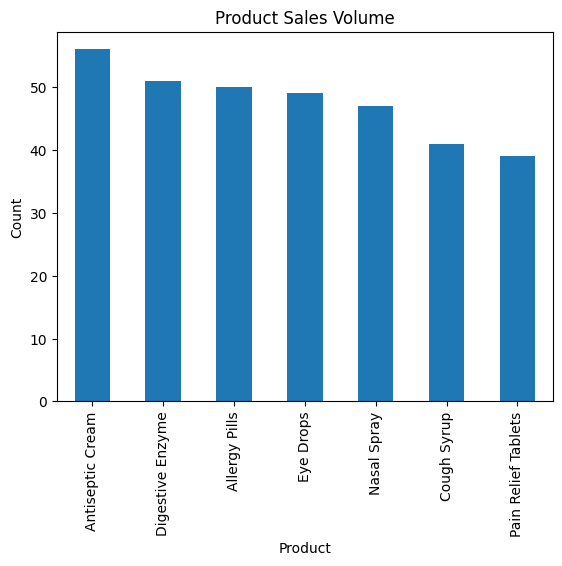

In [11]:
# Top products by transaction count
data['Product'].value_counts().plot(kind='bar', title='Product Sales Volume')

# Revenue per box distribution
sns.histplot(data['Revenue_per_Box'], bins=20, kde=True)

# EDA (Exploratory Data Analysis)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21188\4180989709.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='Date')['Amount'].sum()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21188\4180989709.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x=product_sales.values, y=product_sales.index,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21188\4180989709.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[3], x=country_dist.values, y=country_dist.index,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21188\4180989709.py:91: FutureWarning: 

Passing `palette` without assi

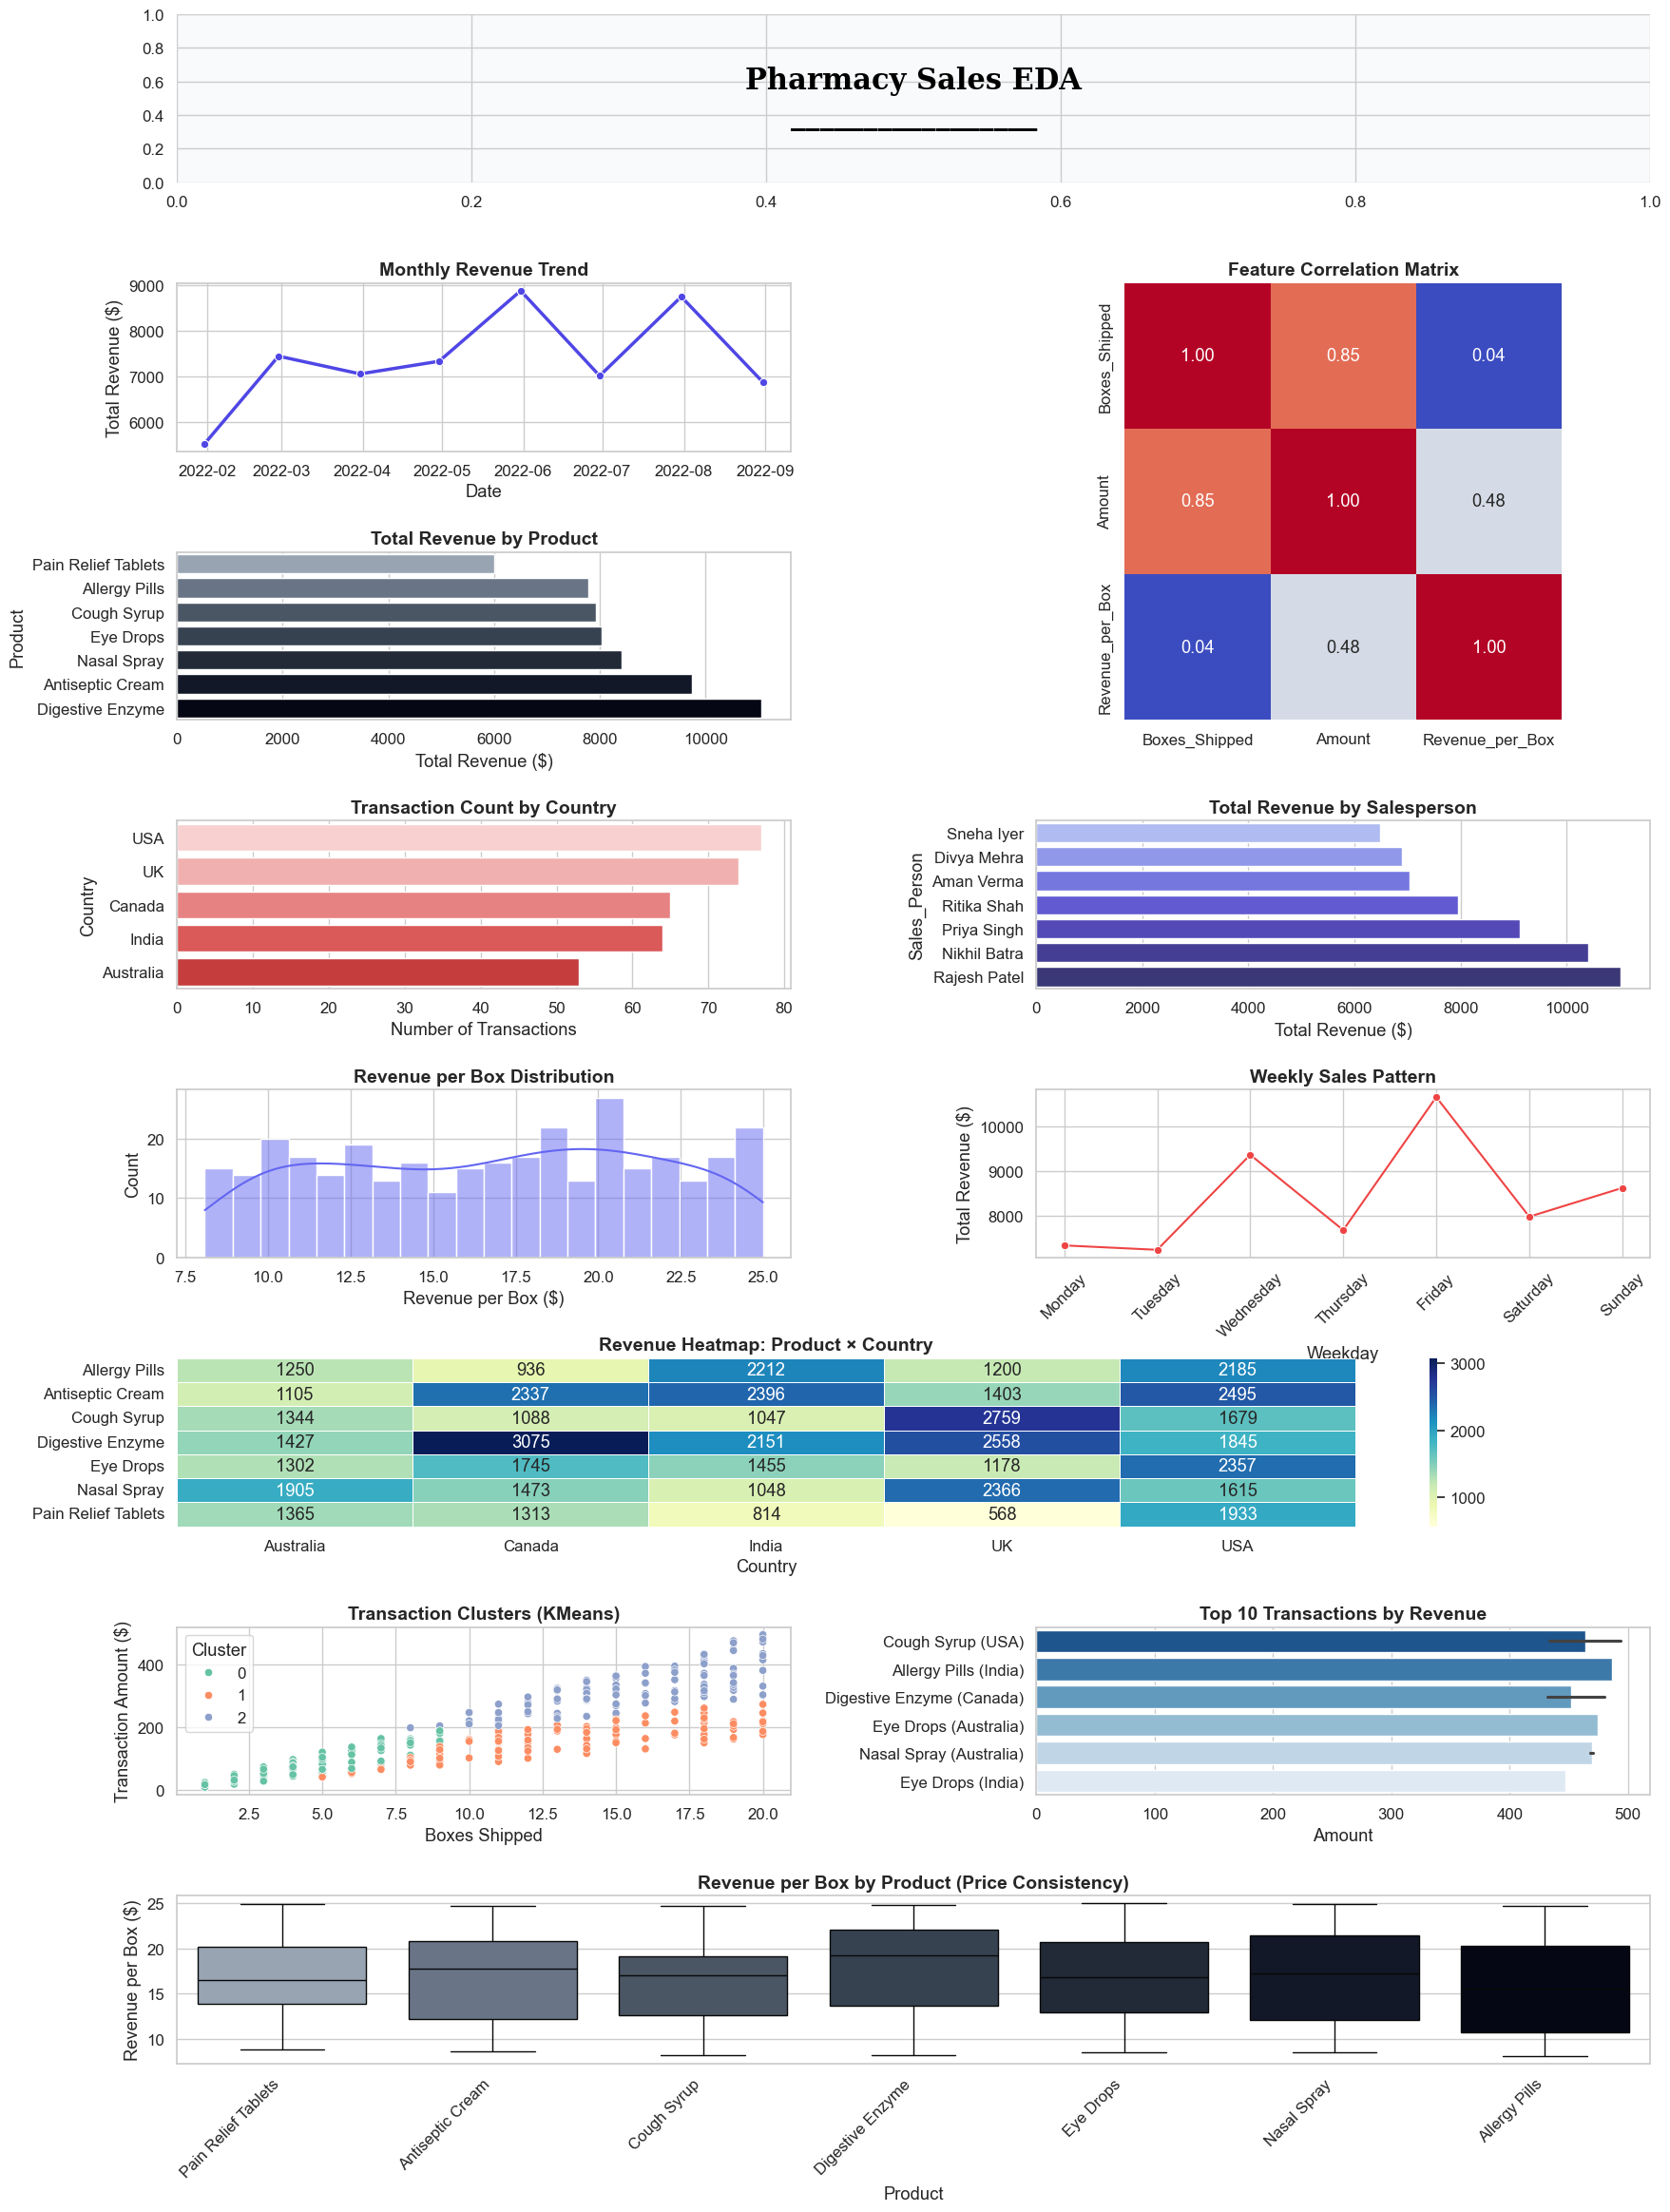

In [12]:
# Data in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set background and color palette
background_color = "#f8fafc"
product_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b", "#0f172a", "#020617"]
country_palette = ["#fecaca", "#fca5a5", "#f87171", "#ef4444", "#dc2626"]
salesperson_palette = ["#a5b4fc", "#818cf8", "#6366f1", "#4f46e5", "#4338ca", "#3730a3", "#312e81"]

sns.set(style="whitegrid", font_scale=1.1)

# Create derived features
data['Revenue_per_Box'] = data['Amount'] / data['Boxes_Shipped']
data['Month'] = data['Date'].dt.month_name()
data['Weekday'] = data['Date'].dt.day_name()

# 📊 Overall Layout with GridSpec
fig = plt.figure(figsize=(20, 28))
gs = fig.add_gridspec(8, 2)
gs.update(wspace=0.4, hspace=0.6)

# Title subplot
title_ax = fig.add_subplot(gs[0, :])
title_ax.set_facecolor(background_color)
for spine in ['bottom', 'left', 'top', 'right']:
    title_ax.spines[spine].set_visible(False)
title_ax.tick_params(left=False, bottom=False)
title_ax.text(0.5, 0.5,
                'Pharmacy Sales EDA\n_________________',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=22, fontweight='bold',
                fontfamily='serif',
                color="#000000")

# Assign axes
axes = [
    # 1. Monthly Sales Trend
    fig.add_subplot(gs[1, 0]),  
    # 2. Correlation Heatmap
    fig.add_subplot(gs[1:3, 1]),  
    # 3. Product Performance
    fig.add_subplot(gs[2, 0]),  
    # 4. Country Distribution
    fig.add_subplot(gs[3, 0]),  
    # 5. Salesperson Performance
    fig.add_subplot(gs[3, 1]),  
    # 6. Revenue per Box Distribution
    fig.add_subplot(gs[4, 0]),  
    # 7. Weekday Sales Pattern
    fig.add_subplot(gs[4, 1]),  
    # 8. Product-Country Heatmap
    fig.add_subplot(gs[5, :]),  
    # 9. Sales Clustering
    fig.add_subplot(gs[6, 0]),  
    # 10. Top Transactions
    fig.add_subplot(gs[6, 1]),  
    # 11. Price Consistency
    fig.add_subplot(gs[7, :])   
]

# 1️⃣ Monthly Sales Trend
monthly_sales = data.resample('M', on='Date')['Amount'].sum()
sns.lineplot(ax=axes[0], x=monthly_sales.index, y=monthly_sales, marker='o', 
                color='#4f46e5', linewidth=2.5)
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Revenue ($)')

# 2️⃣ Correlation Heatmap
corr = data[['Boxes_Shipped', 'Amount', 'Revenue_per_Box']].corr()
sns.heatmap(ax=axes[1], data=corr, annot=True, cmap="coolwarm", 
            fmt=".2f", square=True, cbar=False)
axes[1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 3️⃣ Product Performance
product_sales = data.groupby('Product')['Amount'].sum().sort_values()
sns.barplot(ax=axes[2], x=product_sales.values, y=product_sales.index, 
            palette=product_palette)
axes[2].set_title('Total Revenue by Product', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total Revenue ($)')

# 4️⃣ Country Distribution
country_dist = data['Country'].value_counts()
sns.barplot(ax=axes[3], x=country_dist.values, y=country_dist.index, 
            palette=country_palette)
axes[3].set_title('Transaction Count by Country', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Number of Transactions')

# 5️⃣ Salesperson Performance
sales_perf = data.groupby('Sales_Person')['Amount'].sum().sort_values()
sns.barplot(ax=axes[4], x=sales_perf.values, y=sales_perf.index, 
            palette=salesperson_palette)
axes[4].set_title('Total Revenue by Salesperson', fontsize=14, fontweight='bold')
axes[4].set_xlabel('Total Revenue ($)')

# 6️⃣ Revenue per Box Distribution
sns.histplot(ax=axes[5], data=data, x='Revenue_per_Box', bins=20, 
                kde=True, color='#6366f1')
axes[5].set_title('Revenue per Box Distribution', fontsize=14, fontweight='bold')
axes[5].set_xlabel('Revenue per Box ($)')

# 7️⃣ Weekday Sales Pattern
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = data.groupby('Weekday')['Amount'].sum().reindex(weekday_order)
sns.lineplot(ax=axes[6], x=weekday_sales.index, y=weekday_sales.values, 
                color='#ef4444', marker='o')
axes[6].set_title('Weekly Sales Pattern', fontsize=14, fontweight='bold')
axes[6].set_ylabel('Total Revenue ($)')
axes[6].tick_params(axis='x', rotation=45)

# 8️⃣ Product-Country Heatmap
product_country = pd.crosstab(data['Product'], data['Country'], 
                                values=data['Amount'], aggfunc='sum')
sns.heatmap(ax=axes[7], data=product_country, cmap="YlGnBu", annot=True, 
            fmt=".0f", linewidths=.5)
axes[7].set_title('Revenue Heatmap: Product × Country', fontsize=14, fontweight='bold')
axes[7].set_ylabel('')

# 9️⃣ Sales Clustering (KMeans)
features = data[['Boxes_Shipped', 'Amount', 'Revenue_per_Box']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

sns.scatterplot(ax=axes[8], data=data, x='Boxes_Shipped', y='Amount', 
                hue='Cluster', palette='Set2')
axes[8].set_title('Transaction Clusters (KMeans)', fontsize=14, fontweight='bold')
axes[8].set_xlabel('Boxes Shipped')
axes[8].set_ylabel('Transaction Amount ($)')

# 🔟 Top Transactions
top_transactions = data.nlargest(10, 'Amount')[['Date', 'Product', 'Country', 'Amount']]
top_transactions['Label'] = top_transactions.apply(
    lambda x: f"{x['Product']} ({x['Country']})", axis=1)
sns.barplot(ax=axes[9], data=top_transactions, x='Amount', y='Label', 
            palette='Blues_r')
axes[9].set_title('Top 10 Transactions by Revenue', fontsize=14, fontweight='bold')
axes[9].set_ylabel('')

# 1️⃣1️⃣ Price Consistency by Product
sns.boxplot(ax=axes[10], data=data, x='Product', y='Revenue_per_Box', 
            palette=product_palette)
axes[10].set_title('Revenue per Box by Product (Price Consistency)', 
                    fontsize=14, fontweight='bold')
axes[10].set_xticklabels(axes[10].get_xticklabels(), rotation=45, ha='right')
axes[10].set_ylabel('Revenue per Box ($)')

plt.tight_layout()
plt.show()

## Time Series Forecasting (Prophet)

23:33:27 - cmdstanpy - INFO - Chain [1] start processing
23:33:27 - cmdstanpy - INFO - Chain [1] done processing


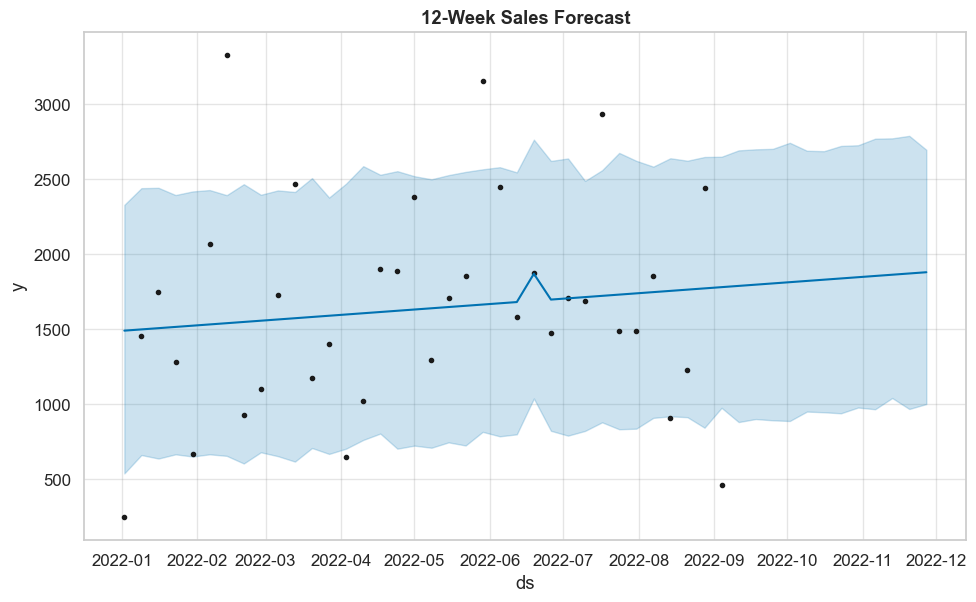

In [13]:
# Prepare data
forecast_df = data.resample('W', on='Date')['Amount'].sum().reset_index()
forecast_df.columns = ['ds', 'y']

# Fit model
model = Prophet(seasonality_mode='multiplicative')
model.add_country_holidays(country_name="US")
model.fit(forecast_df)

# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title('12-Week Sales Forecast', fontweight='bold')
plt.show()

## Trend Analysis (STL Decomposition)

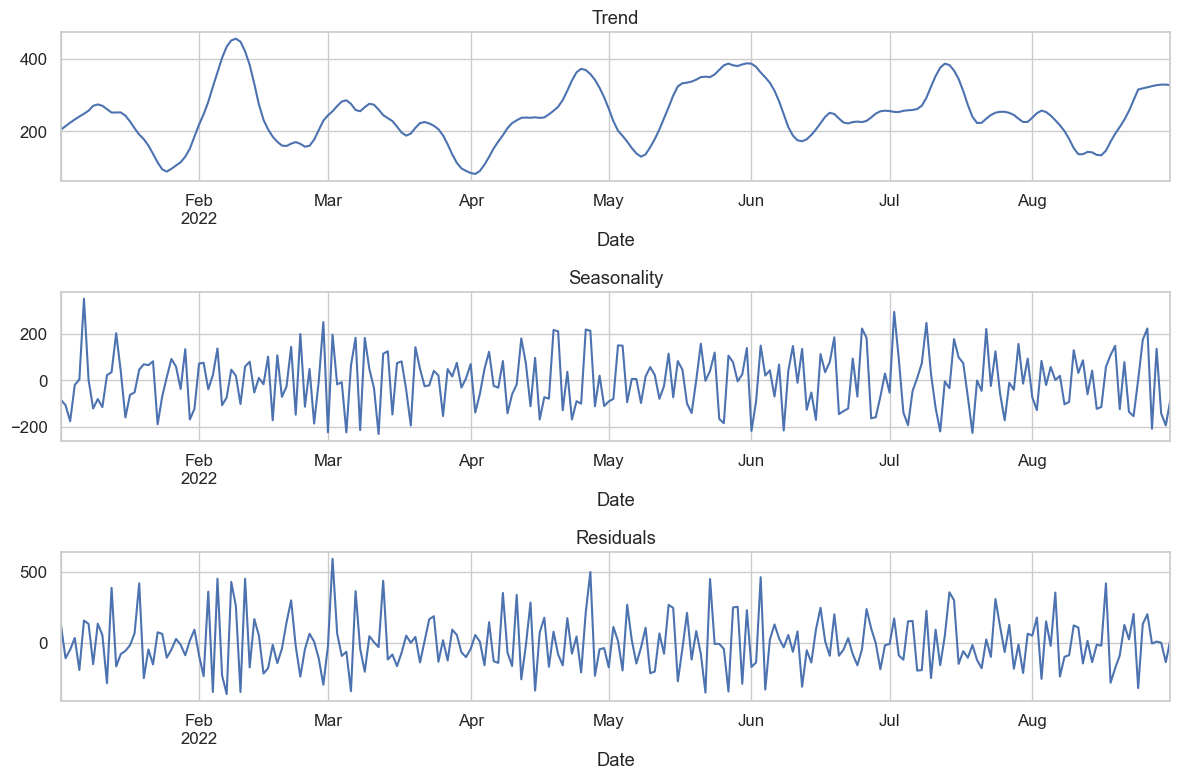

In [14]:
ts = data.resample('D', on='Date')['Amount'].sum()
res = STL(ts, period=7).fit()

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,8))
res.trend.plot(ax=ax1, title='Trend')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.resid.plot(ax=ax3, title='Residuals')
plt.tight_layout()

## Dashboard (Plotly)

In [15]:
# Product-country heatmap
fig = px.imshow(product_country, 
                labels=dict(x="Country", y="Product", color="Revenue"),
                title="Revenue by Product & Country")
fig.show()

# Salesperson performance
fig = px.sunburst(data, path=['Country', 'Sales_Person'], 
                values='Amount', title='Sales Team Performance')
fig.show()

## Machine Learning for Retail Analytics

In [16]:
# Create ML-ready features
ml_data = data.assign(
    day_of_week=data['Date'].dt.dayofweek,
    is_weekend=data['Date'].dt.weekday >= 5,
    price_tier=pd.qcut(data['Revenue_per_Box'], q=3, labels=['Low', 'Med', 'High'])
)

# One-hot encode categoricals
ml_data = pd.get_dummies(ml_data, columns=['Product', 'Country', 'Sales_Person'])

### Model Pipeline

In [17]:
# Create ML-ready features
ml_data = data.assign(
    day_of_week=data['Date'].dt.dayofweek,
    month=data['Date'].dt.month,
    is_weekend=data['Date'].dt.weekday >= 5,
    price_tier=pd.qcut(data['Revenue_per_Box'], q=3, labels=[0, 1, 2])  # Numerical labels
)

# Separate features and target
X = ml_data[['Boxes_Shipped', 'day_of_week', 'month', 'is_weekend', 'price_tier',
                'Product', 'Country', 'Sales_Person']]
y = ml_data['Amount']  # or 'is_high_value' for classification

# Define preprocessing
numeric_features = ['Boxes_Shipped', 'day_of_week', 'month', 'price_tier']
categorical_features = ['Product', 'Country', 'Sales_Person']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Classification example (High-Value Transaction Prediction)
ml_data['is_high_value'] = ml_data['Amount'] > ml_data['Amount'].quantile(0.8)
y_class = ml_data['is_high_value']

In [18]:
# Split data with proper preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2)

# Create pipeline
clf = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42)
)

clf.fit(X_train, y_train)

# Evaluate
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.87      1.00      0.93        53
        True       1.00      0.43      0.60        14

    accuracy                           0.88        67
   macro avg       0.93      0.71      0.76        67
weighted avg       0.90      0.88      0.86        67



In [19]:
reg = make_pipeline(
    preprocessor,
    XGBRegressor(random_state=42)
)

# y_train for regression
reg.fit(X_train, y_train[y_train.index])  

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Boxes_Shipped',
                                                   'day_of_week', 'month',
                                                   'price_tier']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Product', 'Country',
                                                   'Sales_Person'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=Non...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

<Axes: >

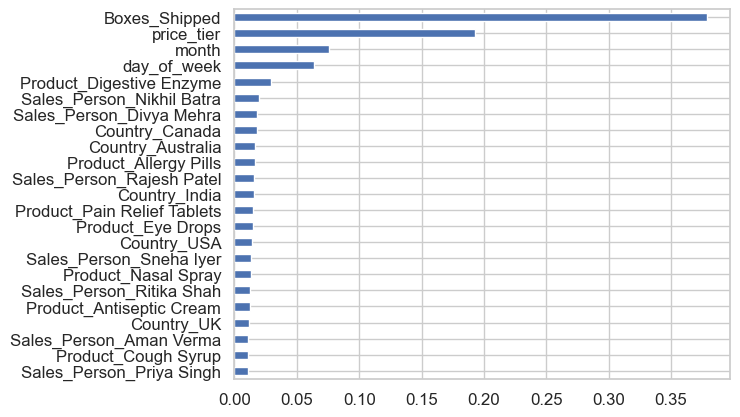

In [20]:
importances = clf.named_steps['randomforestclassifier'].feature_importances_
# Get feature names after one-hot encoding
feature_names = (numeric_features + 
                 list(clf.named_steps['columntransformer']
                     .named_transformers_['cat']
                     .get_feature_names_out()))
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh')

In [21]:
params = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10]
}
grid = GridSearchCV(clf, params, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Boxes_Shipped',
                                                                          'day_of_week',
                                                                          'month',
                                                                          'price_tier']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Product',
                                                                          'Country',
                                                                          'Sales_Person'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 5, 10],
                         'randomforestclassifier__n_estimators': [100, 200]})